# Diffusers - Hugging Face

"Diffusers is the go-to library for state-of-the-art pretrained diffusion models for generating images, audio, and even 3D structures of molecules. Whether you're looking for a simple inference solution or training your own diffusion models, 🤗 Diffusers is a modular toolbox that supports both. Our library is designed with a focus on usability over performance, simple over easy, and customizability over abstractions."

(Diffusers Library Info)

## Requirements

In [1]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

In [2]:
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

## Access Tokens

In [26]:
from huggingface_hub import notebook_login

notebook_login()

## Helping functions

In [4]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dreambooth

Dreambooth let's us create our own model variant with some extra knowledge of a specific face, object or style.

Here's an example using a model trained on 5 photos of a popular children's toy called "Mr Potato Head".

In [5]:
from diffusers import StableDiffusionPipeline

model_id = "sd-dreambooth-library/mr-potato-head"

# Pipeline
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

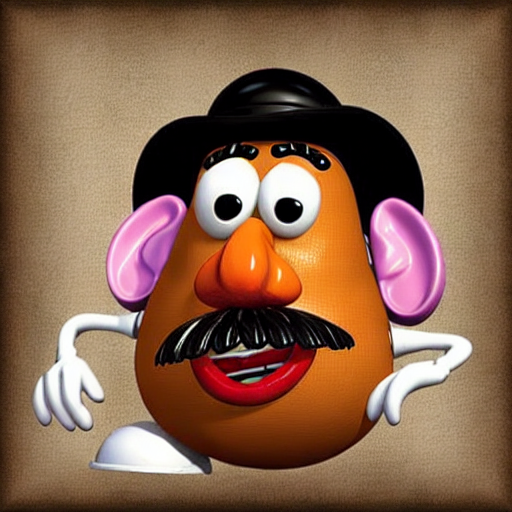

In [6]:
prompt = "an abstract oil painting of sks mr potato head by dali"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image

The `'sks'` token represents a unique identifier for the novel concept in this case - what happens if you leave that out? You can also experiment with changing the number of sampling steps (how low can you go?) and the guidance_scale, which determines how much the model will try to match the prompt.

## Minimum Viable Pipeline (MVP)

Pipelines are great for end-users, in this notebook we're going to build our own pipeline capable of generating small butterfly pictures.

Here's a Pipeline final result in action:

  0%|          | 0/1000 [00:00<?, ?it/s]

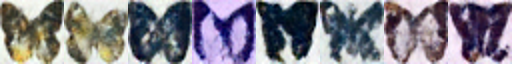

In [7]:
from diffusers import DDPMPipeline

# Load the butterfly pipeline
butterfly_pipeline = DDPMPipeline.from_pretrained(
    "johnowhitaker/ddpm-butterflies-32px"
).to(device)

# Create 8 images
images = butterfly_pipeline(batch_size=8).images

# View the result
make_grid(images)

Not as impressive as the DreamBooth example perhaps, but then we're training from scratch with ~0.0001% of the data used to train Stable Diffusion.

Training a diffusion model looks something like this:

1. Load in some images from the training data
2. Add noise, in different amounts.
3. Feed the noisy versions of the inputs into the model
4. Evaluate how well the model does at denoising these inputs
5. Use this information to update the model weights, and repeat


## From Scratch

### Download dataset for training

For this example, we'll use a dataset of images from the Hugging Face Hub. Specifically, this collection of 1000 butterfly pictures.

In [8]:
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# Or load images from a local folder
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

X shape: torch.Size([8, 3, 32, 32])


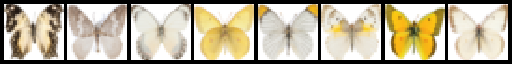

In [9]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

### Define the Scheduler

In diffusers, these processes are both handled by the scheduler. The noise schedule determines how much noise is added at different timesteps.

In [10]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

Ploting `sqrt_alpha_prod` and `sqrt_one_minus_alpha_prod` to view how the input (x) and the noise are scaled and mixed across different timesteps:

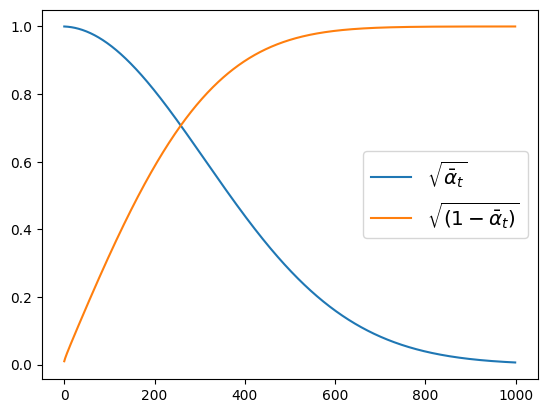

In [11]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Whichever scheduler you've chosen, we can now use it to add noise in different amounts using the `noise_scheduler.add_noise` function like so:

Noisy X shape torch.Size([8, 3, 32, 32])


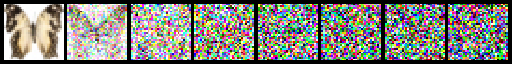

In [12]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

### Define the Model

Most diffusion models use architectures that are some variant of a U-net and that's what we'll use here. Diffusers provides us a handy UNet2DModel class which creates the desired architecture in PyTorch.

In [13]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

When dealing with higher-resolution inputs you may want to use more down and up-blocks, and keep the attention layers only at the lowest resolution (bottom) layers to reduce memory usage.

In [14]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

### Trainig

We run through the data batch by batch and update the parameters of our model each step using an optimizer.

In [15]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:135: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch:5, loss: 0.13876906596124172
Epoch:10, loss: 0.11279807146638632
Epoch:15, loss: 0.0950934374704957
Epoch:20, loss: 0.08602270158007741
Epoch:25, loss: 0.07720889453776181
Epoch:30, loss: 0.07597016403451562


Plotting the loss, we see that the model rapidly improves initially and then continues to get better at a slower rate.

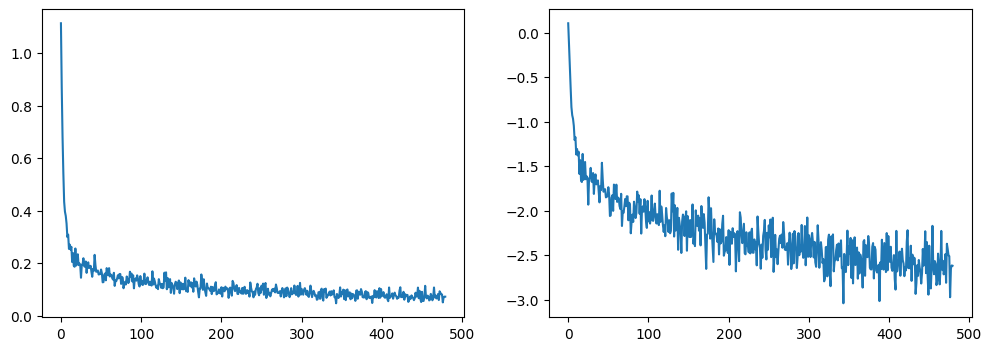

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

### Images Generation

#### Option 1: Pipeline creation

In [17]:
image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

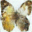

In [18]:
pipeline_output = image_pipe()
pipeline_output.images[0]

In [19]:
image_pipe.save_pretrained("my_pipeline")

In [20]:
!ls my_pipeline/

model_index.json  scheduler  unet


In [21]:
!ls my_pipeline/unet/

config.json  diffusion_pytorch_model.bin


#### Option 2: Writing a Sampling Loop

If you inspect the forward method of the pipeline you'll be able to see what is happening when we run `image_pipe()`:

In [22]:
# ??image_pipe.forward

We begin with random noise, and run through the scheduler timesteps from most to least noisy, removing a small amount of noise each step based on the model prediction:

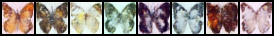

In [23]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

### Upload model to the Hub

In the example above we saved our pipeline to a local folder.

To push our model to the Hub, we will need to model repository to push our files to. We'll determine the repository name from the model ID we want to give our model, it just needs to contain your username. Use the function `get_full_repo_name()`.

In [24]:
from huggingface_hub import get_full_repo_name

model_name = "sd-class-butterflies-32px"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'crisrv/sd-class-butterflies-32px'

Create a model repository on the Hub and push our model:

In [28]:
from huggingface_hub import HfApi, create_repo

create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path="my_pipeline/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(folder_path="my_pipeline/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="my_pipeline/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

diffusion_pytorch_model.bin:   0%|          | 0.00/74.3M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

'https://huggingface.co/crisrv/sd-class-butterflies-32px/blob/main/model_index.json'

The last thing to do is create a nice model card so that our butterfly generator can easily be found on the Hub:


In [29]:
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card

This model is a diffusion model for unconditional image generation of butterflies.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

'https://huggingface.co/crisrv/sd-class-butterflies-32px/blob/main/README.md'

Now that the model is on the Hub, you can download it from anywhere by using the from_pretrained() method of the DDPMPipeline as follows.

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

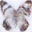

In [30]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline.from_pretrained(hub_model_id)
pipeline_output = image_pipe()
pipeline_output.images[0]